In [1]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent)
os.chdir(Path(os.path.abspath('')).parent)

import numpy as np
import pandas as pd 
import xarray as xr

import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            focus_scenarios,
                            cmap_diverging,
                            cmap_negref
                            )

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box
from matplotlib.gridspec import GridSpec

import matplotlib as mpl
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['hatch.linewidth'] = cset.hatch_linewidth 
# Set global linewidth for all plotted lines
mpl.rcParams['lines.linewidth'] = cset.linewidth  # adjust as needed

# Set global linewidth for figure borders (spines)
mpl.rcParams['axes.linewidth'] = cset.border_linewidth   # frame around plots
mpl.rcParams['xtick.labelsize'] = labelsize_small
mpl.rcParams['ytick.labelsize'] = labelsize_small
mpl.rcParams['axes.labelsize'] = labelsize_medium
mpl.rcParams['axes.titlesize'] = labelsize_large
mpl.rcParams['legend.fontsize'] = labelsize_medium

mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1


## Load Data

a. GMT

In [2]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)


b. GDP

In [3]:
gdp_dfs = [pd.read_csv(cset.path_INTERIM_GDP / file_name) for file_name in cset.GDP_interim_dataset_names]

In [ ]:
# gdp_df = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
# gdp_df = gdp_df[gdp_df.scen != 'Ref1p5']
# gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
# gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)

c. local temperature 

In [4]:
tas_df = pd.read_csv(cset.file_tas)
iso = 'IND'
tas_tmp = tas_df[(tas_df.iso == iso) & (tas_df.run.str.contains('ssp534-over'))].loc[:, 'tas'].values.reshape(100, -1).T

In [5]:
gdp_tmps = []
for i in range(3):
    gdp_df = gdp_dfs[i].copy()
    gdp_ref = gdp_df[(gdp_df.scen == 'ssp534-over') & (gdp_df.iso == iso) & (gdp_df.year == 2015)].loc[:, 'SSP2_clim'].values.mean()
    if i != 2: 
        gdp_tmp = gdp_df[(gdp_df.scen == 'ssp534-over') & (gdp_df.iso == iso)].loc[:, 'SSP2_clim'].values.reshape(100,-1).T/gdp_ref*100
    else: 
        gdp_tmp = gdp_df[(gdp_df.scen == 'ssp534-over') & (gdp_df.iso == iso)].loc[:, 'SSP2_clim'].values.reshape(-1,100)/gdp_ref*100
        
    gdp_tmps.append(gdp_tmp)

## Plot

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_13104/500257805.py:83: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


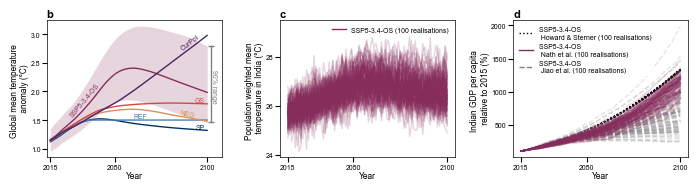

In [18]:
# with sns.axes_style('whitegrid'):
fig, axes = plt.subplots(1, 3, figsize=(cset.fig_width, cset.fig_height/3.5), constrained_layout=True)

linestyles = [(0, (1,1)), '-', (0, (5,1))]

ax = axes[0] 
for i, scenario in enumerate(focus_scenarios):
        ax.plot(gmt_ds.index, 
                gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values.mean(axis = 1), 
                color = focus_scenarios_color_dict[scenario],
                label = focus_scenarios_labels[i])
        if scenario == 'ssp534-over':
                ax.fill_between(gmt_ds.index, 
                                np.quantile(gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values, 0.05, axis = 1), 
                                np.quantile(gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values, 0.95, axis = 1),
                                color = focus_scenarios_color_dict[scenario],
                                lw = 0,
                                alpha = .2)
ax.text(2085, 2.72, 'CurPol', color = focus_scenarios_color_dict['CurPol'], fontsize = labelsize_small, rotation = 37)
ax.text(2094, 1.35, 'SP', color = focus_scenarios_color_dict['SP'], fontsize = labelsize_small, rotation = 0)
ax.text(2060, 1.53, 'REF', color = focus_scenarios_color_dict['Ref'], fontsize = labelsize_small, rotation = 0)
ax.text(2085, 1.55, 'NEG', color = focus_scenarios_color_dict['Neg'], fontsize = labelsize_small, rotation = -12)
ax.text(2093, 1.82, 'GS', color = focus_scenarios_color_dict['GS'], fontsize = labelsize_small, rotation = 0)
ax.text(2025, 1.56, 'SSP5-3.4-OS', color = focus_scenarios_color_dict['ssp534-over'], fontsize = labelsize_small, rotation = 50)
ax.plot([2102, 2102], np.quantile(gmt_ds.loc[:, gmt_ds.columns.str.contains('ssp534-over')].values, q = [0.05, 0.95], axis = 1)[:,-1], marker = '_', lw = 1, color = 'grey',
        markersize = cset.marker_size)
ax.text(2102.3, 2.1, rotation = 270, s = f'90% range', fontsize = labelsize_small, color = 'grey', va = 'center')

ax.set_xticks([2015, 2050, 2100],
                [2015, 2050, 2100],
                fontsize= labelsize_small)
ax.set_yticks([1.0, 1.5, 2.0, 2.5, 3.0], 
                [1.0, 1.5, 2.0, 2.5, 3.0],
                fontsize= labelsize_small)
ax.set_xlabel('Year', 
                fontsize=labelsize_medium)
ax.set_ylabel('Global mean temperature \n anomaly (°C)', 
                fontsize=labelsize_medium)
ax.set_xlim(2013, 2108)

ax = axes[1]
ax.plot(gmt_ds.index, tas_tmp, color = focus_scenarios_color_dict['ssp534-over'], lw = 1, alpha = .2)
ax.plot([], [], color = focus_scenarios_color_dict['ssp534-over'], lw = 1, alpha = 1, label = 'SSP5-3.4-OS (100 realisations)')
ax.set_xticks([2015, 2050, 2100], 
                [2015, 2050, 2100], 
                fontsize = labelsize_small)
ax.set_yticks([24,26,28], 
                [24,26,28], 
                fontsize = labelsize_small)
ax.set_xlabel('Year', fontsize = labelsize_medium)
ax.set_ylabel('Population weighted mean \n temperature in India (°C)', fontsize = labelsize_medium)
ax.legend(fontsize = labelsize_small, 
        facecolor = (1,1,1,0.7),
        edgecolor = 'None')
ax.set_ylim(23.9, 29.5)

ax = axes[2]
for i, gdp_tmp in enumerate(gdp_tmps): 
        if i == 1:
                ax.plot(gmt_ds.index, gdp_tmp, color = focus_scenarios_color_dict['ssp534-over'], lw = 1, alpha = .2, linestyle = '-', zorder = 5)
                ax.plot([], [], color = focus_scenarios_color_dict['ssp534-over'], lw = 1, alpha = 1, label = f'SSP5-3.4-OS \n {cset.GDP_labels[i]} (100 realisations)')
        if i == 0: 
                ax.plot(gmt_ds.index, gdp_tmp, color = 'black', lw = 1, alpha = .2, linestyle = 'dotted')
                ax.plot([], [], color = 'black', lw = 1, alpha = 1, linestyle ='dotted', label = f'SSP5-3.4-OS \n {cset.GDP_labels[i]} (100 realisations)')
        if i == 2:
                ax.plot(gmt_ds.index, gdp_tmp, color = 'grey', lw = 1, alpha = .2, linestyle = '--')
                ax.plot([], [], color = 'grey', lw = 1, alpha = 1, linestyle ='--', label = f'SSP5-3.4-OS \n {cset.GDP_labels[i]} (100 realisations)')
ax.set_xticks([2015, 2050, 2100],
                [2015, 2050, 2100], 
                fontsize = labelsize_small)
ax.set_yticks([500,1000,1500,2000], 
                [500,1000,1500,2000], 
                fontsize = labelsize_small)
ax.set_xlabel('Year', fontsize = labelsize_medium)
ax.set_ylabel('Indian GDP per capita \n relative to 2015 (%)', 
                fontsize = labelsize_medium)
ax.legend(fontsize = labelsize_small, 
        facecolor = (1,1,1,0.7),
        edgecolor = 'None')

for i, ax in enumerate(axes): 
        ax.text(0.0, 1.08, ['b', 'c', 'd'][i], transform=ax.transAxes,fontsize=labelsize_large+1, fontweight='bold', va='top')
plt.tight_layout()
plt.savefig(cset.path_GRAPHICS / '001_stylised_modelling_chain.pdf', dpi = 600)
plt.show()